# FoldAR
##### Ian Brown, Tani Cath, Tom Cavey
##### Colorado State University
##### CS567 3D User Interfaces

This Jupyter notebook is used to process the data collected from the FoldAR iOS application. The application is designed to collect hand pose data using the Human Hand Detection model which is part of the VisionOS framework.

Author: Tani Cath

# Imports and Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import re

# Constants
all_columns = ['thumbTip.x', 'thumbTip.y', 'thumbIP.x', 'thumbIP.y', 'thumbMP.x', 'thumbMP.y', 'thumbCMC.x', 'thumbCMC.y',
                  'thumbTip2.x', 'thumbTip2.y', 'thumbIP2.x', 'thumbIP2.y', 'thumbMP2.x', 'thumbMP2.y', 'thumbCMC2.x', 'thumbCMC2.y',
                  'indexTip.x', 'indexTip.y', 'indexPIP.x', 'indexPIP.y', 'indexDIP.x', 'indexDIP.y', 'indexMCP.x', 'indexMCP.y',
                  'indexTip2.x', 'indexTip2.y', 'indexPIP2.x', 'indexPIP2.y', 'indexDIP2.x', 'indexDIP2.y', 'indexMCP2.x', 'indexMCP2.y',
                  'middleTip.x', 'middleTip.y', 'middlePIP.x', 'middlePIP.y', 'middleDIP.x', 'middleDIP.y', 'middleMCP.x', 'middleMCP.y',
                  'middleTip2.x', 'middleTip2.y', 'middlePIP2.x', 'middlePIP2.y', 'middleDIP2.x', 'middleDIP2.y', 'middleMCP2.x', 'middleMCP2.y',
                  'ringTip.x', 'ringTip.y', 'ringPIP.x', 'ringPIP.y', 'ringDIP.x', 'ringDIP.y', 'ringMCP.x', 'ringMCP.y',
                  'ringTip2.x', 'ringTip2.y', 'ringPIP2.x', 'ringPIP2.y', 'ringDIP2.x', 'ringDIP2.y', 'ringMCP2.x', 'ringMCP2.y',
                  'littleTip.x', 'littleTip.y', 'littlePIP.x', 'littlePIP.y', 'littleDIP.x', 'littleDIP.y', 'littleMCP.x', 'littleMCP.y',
                  'littleTip2.x', 'littleTip2.y', 'littlePIP2.x', 'littlePIP2.y', 'littleDIP2.x', 'littleDIP2.y', 'littleMCP2.x', 'littleMCP2.y']


finger_columns = ['thumbTip', 'thumbIP', 'thumbMP', 'thumbCMC', 'thumbTip2', 'thumbIP2', 'thumbMP2', 'thumbCMC2',
                  'indexTip', 'indexPIP', 'indexDIP', 'indexMCP', 'indexTip2', 'indexPIP2', 'indexDIP2', 'indexMCP2',
                  'middleTip', 'middlePIP', 'middleDIP', 'middleMCP', 'middleTip2', 'middlePIP2', 'middleDIP2', 'middleMCP2',
                  'ringTip', 'ringPIP', 'ringDIP', 'ringMCP', 'ringTip2', 'ringPIP2', 'ringDIP2', 'ringMCP2',
                  'littleTip', 'littlePIP', 'littleDIP', 'littleMCP', 'littleTip2', 'littlePIP2', 'littleDIP2', 'littleMCP2']

fingertip_columns = [
    'thumbTip.x', 'thumbTip.y', 'thumbTip2.x', 'thumbTip2.y',
    'indexTip.x', 'indexTip.y', 'indexTip2.x', 'indexTip2.y',
    'middleTip.x', 'middleTip.y', 'middleTip2.x', 'middleTip2.y',
    'ringTip.x', 'ringTip.y', 'ringTip2.x', 'ringTip2.y',
    'littleTip.x', 'littleTip.y', 'littleTip2.x', 'littleTip2.y'
]

tnr = {'fontname': 'Times New Roman'}


# File Management
Gets list of all files in `sessionData` directory; reads the data from a single file into a Pandas DataFrame.

In [2]:
# Read all files in directory, returns list of filenames
def get_files(dir='sessionData'):
    files = [(f) for f in os.listdir(dir) if os.path.isfile(f'{dir}/{f}')]
    return files
    
# Reads individual file, returns datafram and column headers
def read_file(filename: str, dir='sessionData'):
    try:
        data = pd.read_csv(f'{dir}/{filename}')
        # stripping spaces from columns an data...
        data.columns = data.columns.str.strip()
        data:pd.DataFrame = data.map(lambda x: x.strip() if isinstance(x, str) else x)
        return data #, data.columns    
    except:
        print("Error reading file")
        return None

# Data Extraction
Gets specific data from a given frame (single row from file).

In [3]:
def get_timestamp(frame):
    date = frame['date'].iloc[0]
    time = frame['time'].iloc[0]
    timestamp = f'{date} {time}'
    timestamp_datetime = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f')
    
    return timestamp_datetime

def get_frameMean(frame):
    # Euclidean distances of all points
    distances = np.sqrt(np.diff(frame[all_columns].values.reshape(-1, 2), axis=0)**2).sum(axis=1)
    frame_mean = np.mean(distances)
    return frame_mean

def get_tipMean(frame):
    # Euclidean distances of fingertips
    tipDistances = np.sqrt(np.diff(frame[fingertip_columns].values.reshape(-1, 2), axis=0)**2).sum(axis=1)
    tip_mean = np.mean(tipDistances)
    return tip_mean

Gets statistical values from a full DataFrame.

In [4]:
# Returns auxiliary frametime data for a list of frametimes from a single dataset
def get_statistics(data_list, printData=True):
    mean = np.mean(data_list)
    minimum = np.min(data_list)
    maximum = np.max(data_list)
    median = np.median(data_list)
    first_quartile = np.quantile(data_list, 0.25)
    thrid_quartile = np.quantile(data_list, 0.75)
    iqr = thrid_quartile - first_quartile
    std = np.std(data_list)
    
    data = {'mean': mean, 'minimum': minimum, 'maximum': maximum, 'median': median, 'Q1': first_quartile, 'Q3': thrid_quartile, 'IQR': iqr, 'STD': std}
    if printData:
        for k,v in data.items():
            print(f'{k}: {v}')
    
    return data

Gets total time of a given DataFrame

In [5]:
# Returns session duration
def get_session_time(data:pd.DataFrame):
    start = data['date'].iloc[0] + " " + data['time'].iloc[0]
    end = data['date'].iloc[-1] + " " + data['time'].iloc[-1]
            
    start_time = datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f')
    end_time = datetime.strptime(end, '%Y-%m-%d %H:%M:%S.%f')
    
    duration = end_time - start_time
    
    return duration

# Process Data
Reads a Pandas DataFrame and processes each row.

In [6]:
# Processes a single dataset file, returns frame means, tip means, and frametimes
def process_frames(data, print:bool = True):
    frame_means  = []
    tip_means    = []
    finger_means = []
    frametimes   = []

    t0:datetime = None
    # for each frame in dataframe
    for i, frame in data.groupby('frame'):
        timestamp = get_timestamp(frame)
        frame_mean = get_frameMean(frame)
        tip_mean = get_tipMean(frame)
        frame_means.append(frame_mean)
        tip_means.append(tip_mean)
        
        if i != 0:
            frametime:datetime = (timestamp - t0).microseconds/1000
            frametimes.append(frametime)
            
        t0 = timestamp


        if print:
            print(f'Frame {i}:')
            print(f'Timestamp: {timestamp}')
            print(f'Mean Distance: {frame_mean:.2f}')
            print(f'Frametime: {frametime} ms')
        # print(f'Minimum Distance: {frame_min:.2f}')
        # print(f'Maximum Distance: {frame_max:.2f}')
        # print(f'Standard Deviation: {frame_std:.2f}')
            print()
        
    return frame_means, tip_means, frametimes


# Data Plotting
Plots selected mean fingertip data and saves to file.

In [7]:
# Plot all frames
def plot_frames(frame_means, tip_means, filename="", plot=(True,True,True,True,True)):
    window_size = 5
    all_moving_average = np.convolve(frame_means, np.ones(window_size)/window_size, mode='valid')
    tips_moving_average = np.convolve(tip_means, np.ones(window_size)/window_size, mode='valid')
    
    if len(filename) > 0:
        pid = filename[12:17]
        print(pid)
    else:
        pid=filename

    if plot[0]:
        title = 'Mean Fingertip Distances Across Frames'
        newfile = title.replace(' ', '')
        newfile = f'Images/meanDistances/{pid}_{newfile}.png'
        fig = plt.figure(figsize=(8,6))
        plt.plot(range(1, len(tip_means) + 1), frame_means, marker='o', linestyle='-', color='b')
        plt.xlabel('Frame #', **tnr)
        plt.ylabel('Mean Distance (px)', **tnr)
        plt.title(f'{pid} - {title}', **tnr)
        plt.show()
        fig.savefig(newfile)

    if plot[1]:
        title = 'Smoothed Mean Fingertip Distances Across Frames'
        newfile = title.replace(' ', '')
        newfile = f'Images/meanDistances/{pid}_{newfile}.png'
        fig = plt.figure(figsize=(8,6))
        plt.plot(range(1, len(tip_means) + 1)[:len(tips_moving_average)], tips_moving_average, marker='o', linestyle='-', color='b')
        plt.xlabel('Frame #', **tnr)
        plt.ylabel('Mean Distance (px)', **tnr)
        plt.title(f'{pid} - {title}', **tnr)
        plt.show()
        fig.savefig(newfile)

    if plot[2]:
        title = 'Mean Point Distances Across Frames'
        newfile = title.replace(' ', '')
        newfile = f'Images/meanDistances/{pid}_{newfile}.png'
        fig = plt.figure(figsize=(8,6))
        plt.plot(range(1, len(frame_means) + 1), frame_means, marker='o', linestyle='-', color='g')
        plt.xlabel('Frame #', **tnr)
        plt.ylabel('Mean Distance (px)', **tnr)
        plt.title(f'{pid} - {title}', **tnr)
        plt.show()
        fig.savefig(newfile)
        
    if plot[3]:
        title = 'Smoothed Point Frame Distances Across Frames'
        newfile = title.replace(' ', '')
        newfile = f'Images/meanDistances/{pid}_{newfile}.png'
        fig = plt.figure(figsize=(8,6))
        plt.plot(range(1, len(frame_means) + 1)[:len(all_moving_average)], all_moving_average, marker='o', linestyle='-', color='g')
        plt.xlabel('Frame #', **tnr)
        plt.ylabel('Mean Distance (px)', **tnr)
        plt.title(f'{pid} - {title}', **tnr)
        plt.show()
        fig.savefig(newfile)

    start_frame, end_frame = 50, 50
    trimmed_tip_means = tip_means[start_frame:-end_frame]
    trimmed_tips_moving_average = tips_moving_average[start_frame:end_frame + len(trimmed_tip_means)]
    
    if plot[4]:
        title = 'Tips Only Smoothed Mean Distances Across Frames'
        newfile = title.replace(' ', '')
        newfile = f'Images/meanDistances/{pid}_{newfile}.png'
        fig = plt.figure(figsize=(8,6))
        plt.plot(range(start_frame + 1, start_frame + 1 + len(trimmed_tip_means)), trimmed_tips_moving_average, marker='o', linestyle='-', color='b')
        plt.xlabel('Frame #', **tnr)
        plt.ylabel('Mean Distance (px)', **tnr)
        plt.title(f'{pid} - {title}', **tnr)
        plt.show()
        fig.savefig(newfile)

Plots path of given point over entire DataFrame.

In [8]:
# Plots path of given point
def plot_path(data, point_to_plot = 'thumbTip'):
    x_coords = data[f'{point_to_plot}.x']
    y_coords = data[f'{point_to_plot}.y']

    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, label=f'{point_to_plot} Path', c=range(len(x_coords)), cmap='inferno')

    plt.title(f'Path of {point_to_plot}', **tnr)
    plt.colorbar(label='Frame Number')
    # plt.grid(True)
    plt.show()


    point_to_plot = 'littleTip'
    x_coords = data[f'{point_to_plot}.x']
    y_coords = data[f'{point_to_plot}.y']

    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, label=f'{point_to_plot} Path', c=range(len(x_coords)), cmap='inferno')

    plt.title(f'Path of {point_to_plot}', **tnr)
    plt.colorbar(label='Frame Number')
    # plt.grid(True)
    plt.show()

Plots path of a pair of fingers over entire DataFrame.

In [9]:
# Plots path of finger pair
def plot_pairwise(data:pd.DataFrame, finger_name:str='little'):
    ftc = [f'{finger_name}Tip', f'{finger_name}Tip2']

    # pairwise euclidean distances (using fingertips)
    for fingertip1 in ftc:
        for fingertip2 in ftc:
            if fingertip1 != fingertip2:
                data[f'{fingertip1}_{fingertip2}_distance'] = np.sqrt((data[f'{fingertip1}.x'] - data[f'{fingertip2}.x'])**2 +
                                                                    (data[f'{fingertip1}.y'] - data[f'{fingertip2}.y'])**2)
    #plots
    for fingertip1 in ftc:
        for fingertip2 in ftc:
            if fingertip1 != fingertip2:
                distance_column = f'{fingertip1}_{fingertip2}_distance'
                plt.plot(data['frame'], data[distance_column], label=f'{fingertip1} to {fingertip2}')

    plt.xlabel('Frame #', **tnr)
    plt.ylabel('pairwise distance', **tnr)
    plt.title('pairwise distances of fingertips', **tnr)
    plt.show()

# Function Tests
Tests statistics parsing on three files.

In [10]:
# EXECUTE CODE FROM HERE DOWNWARDS

files = ['sessionData-102-0.csv', 'sessionData-205-0.csv', 'sessionData-301-0.csv']
# files = get_files()

for f in files:
    print(f'-----\'{f}\' frametime data-----')
    dataframe = read_file(f)
    fm, tm, ft = process_frames(dataframe, print=False)
    ft_data = get_statistics(ft)
    print('Mean FPS:', 1000/ft_data['mean'])

    

-----'sessionData-102-0.csv' frametime data-----


mean: 35.324786324786324
minimum: 25.0
maximum: 267.0
median: 33.0
Q1: 33.0
Q3: 34.0
IQR: 1.0
STD: 13.877770697818779
Mean FPS: 28.308734575368984
-----'sessionData-205-0.csv' frametime data-----
mean: 33.817843866171
minimum: 27.0
maximum: 134.0
median: 33.0
Q1: 33.0
Q3: 34.0
IQR: 1.0
STD: 6.700739111826935
Mean FPS: 29.570187974057383
-----'sessionData-301-0.csv' frametime data-----
mean: 255.9
minimum: 215.0
maximum: 477.0
median: 237.0
Q1: 234.75
Q3: 243.25
IQR: 8.5
STD: 50.373008645503795
Mean FPS: 3.9077764751856194


Testing plotting functions

mean: 33.35446685878963
minimum: 27.0
maximum: 39.0
median: 33.0
Q1: 33.0
Q3: 34.0
IQR: 1.0
STD: 1.487121057119097
Mean FPS: 29.980991878348018
104-0


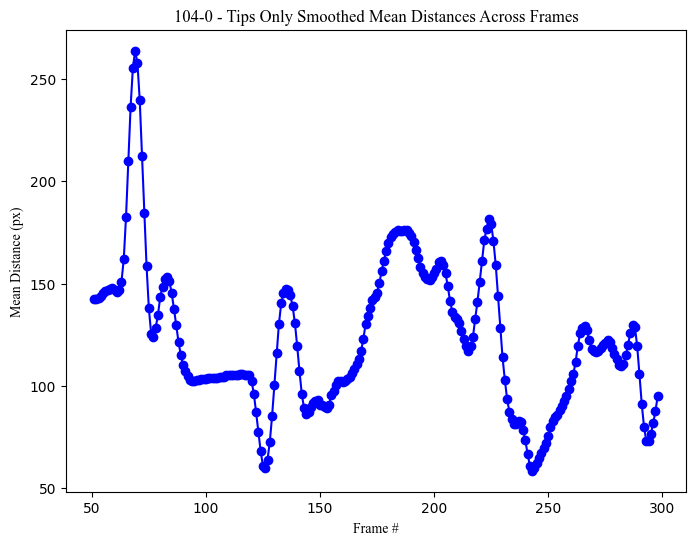

In [11]:
dataframe = read_file('sessionData-104-0.csv')
fm, tm, ft = process_frames(dataframe, print=False)
ft_data = get_statistics(ft)
print('Mean FPS:', 1000/ft_data['mean'])

plot_frames(fm,tm,filename="sessionData-104-0.csv", plot=(False,False,False,False,True))

# Analysis Executions
Reads all files, splits files into groups for different analyses.

In [12]:
files = get_files()

ip8 = []
ip15 = []

mode0 = []
mode1 = []
mode2 = []

for f in files:
    # print(f)
    if re.search('-3\d\d-', f):
        ip8.append(f)
    else:
        ip15.append(f)
        
    if re.search('-0\.csv', f):
        mode0.append(f)
    elif re.search('-1\.csv', f):
        mode1.append(f)
    elif re.search('-2\.csv', f):
        mode2.append(f)
        
print("Total iPhone 15 data files:", len(ip15))
print("Total iPhone 8 data files:", len(ip8))
print("Total files for mode 0:", len(mode0))
print("Total files for mode 1:", len(mode1))
print("Total files for mode 2:", len(mode2))
print()


Total iPhone 15 data files: 33
Total iPhone 8 data files: 9
Total files for mode 0: 14
Total files for mode 1: 14
Total files for mode 2: 14



## iPhone model frametime analysis
Gets average statistical data for all files produced by an Apple iPhone 8.

mean: 245.65264621913502
minimum: 237.99242424242425
maximum: 255.9
median: 242.84530386740332
Q1: 239.8716216216216
Q3: 250.6046511627907
IQR: 10.733029541169088
STD: 6.703867079452198
Mean FPS: 4.070788633426516
Frametime statistics for all iPhone 8 data:


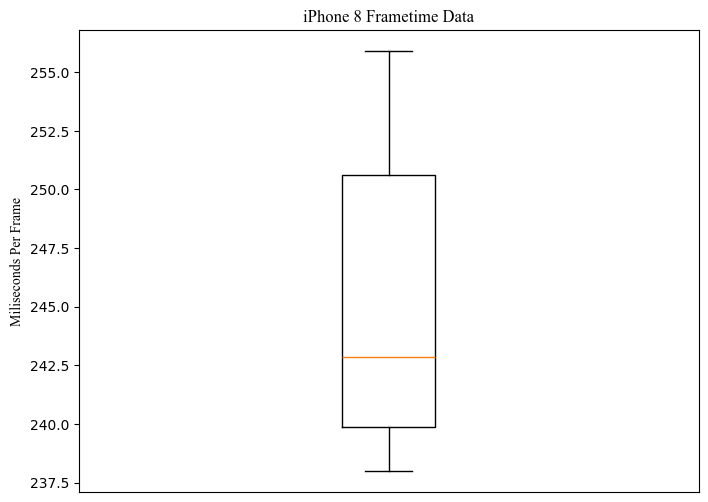

In [13]:
ip8_avg = []

for f in ip8:
    dataframe = read_file(f)
    fm, tm, ft = process_frames(dataframe, print=False)
    ft_data = get_statistics(ft, printData=False)

    ip8_avg.append(ft_data['mean'])

ip8_all_avg = get_statistics(ip8_avg)
print('Mean FPS:', 1000/ip8_all_avg['mean'])
print("Frametime statistics for all iPhone 8 data:")


fig = plt.figure(figsize =(8, 6))
plt.boxplot(ip8_avg)
plt.title("iPhone 8 Frametime Data", **tnr)
plt.ylabel("Miliseconds Per Frame", **tnr)
plt.xticks([])
plt.show()

fig.savefig('Images/boxPlots/iPhone8Frametimes.png')

Gets average statistical data for all files produced by an Apple iPhone 15 Pro Max.


mean: 34.03900850752302
minimum: 33.28542914171657
maximum: 35.843283582089555
median: 33.817843866171
Q1: 33.42587601078167
Q3: 34.27028639618138
IQR: 0.844410385399712
STD: 0.7150020028527626
Mean FPS: 29.378058993081076
Frametime statistics for all iPhone 15 Pro Max data:


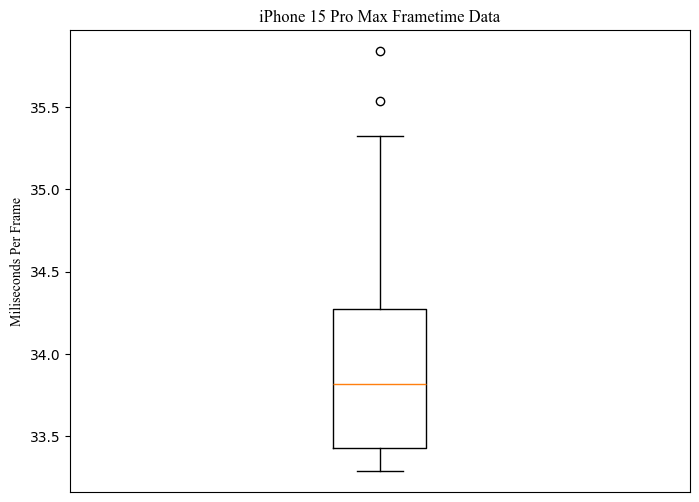

In [14]:
print()
ip15_avg = []
for f in ip15:
    dataframe = read_file(f)
    fm, tm, ft = process_frames(dataframe, print=False)
    ft_data = get_statistics(ft, printData=False)

    ip15_avg.append(ft_data['mean'])

        
ip15_all_avg = get_statistics(ip15_avg)
print('Mean FPS:', 1000/ip15_all_avg['mean'])
print("Frametime statistics for all iPhone 15 Pro Max data:")
        
fig = plt.figure(figsize =(8, 6))
plt.boxplot(ip15_avg)
plt.title("iPhone 15 Pro Max Frametime Data", **tnr)
plt.ylabel("Miliseconds Per Frame", **tnr)
plt.xticks([])
plt.show()

fig.savefig('Images/boxPlots/iPhone15Frametimes.png')

Generates box double box plot for both iPhone models.

<Figure size 800x600 with 0 Axes>

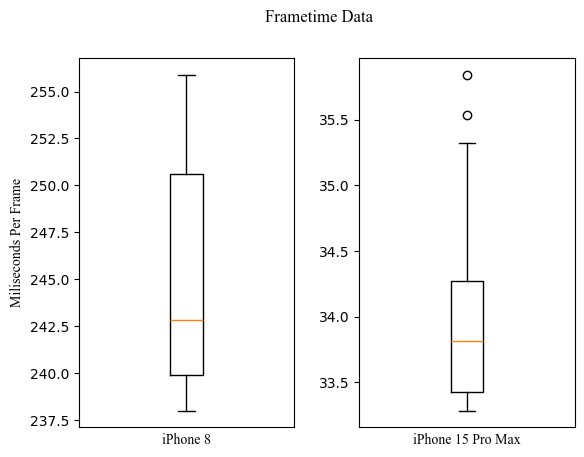

In [15]:
plt.figure(figsize =(8, 6))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.boxplot(ip8_avg)
ax2.boxplot(ip15_avg)
ax1.set_xlabel("iPhone 8", **tnr)
ax1.set_xticks([])
ax1.set_ylabel("Miliseconds Per Frame", **tnr)
ax2.set_xlabel("iPhone 15 Pro Max", **tnr)
ax2.set_xticks([])

# plt.boxplot([ip8_avg, ip15_avg])
plt.suptitle("Frametime Data", **tnr)
# plt.ylabel("Miliseconds Per Frame")
plt.subplots_adjust(wspace=0.3) 
plt.show()

fig.savefig('Images/boxPlots/FrametimeBoxPlot.png')

## User Mode Completion Time Analysis
Gets statistics for mode 0 (full vision).

In [16]:
mode0_times = []
for f in mode0:
    # print(f)
    dataframe = read_file(f)
    duration = get_session_time(dataframe).total_seconds()
    mode0_times.append(duration)
    print(f'{f[12:17]}: {duration}')

print()    

mode0_stats = get_statistics(mode0_times)



102-0: 24.798


103-0: 16.676
104-0: 11.574
105-0: 16.771
106-0: 18.743
107-0: 21.981
108-0: 20.48
205-0: 9.097
206-0: 3.559
208-0: 9.557
210-0: 72.903
300-0: 31.415
301-0: 20.472
302-0: 35.501

mean: 22.394785714285714
minimum: 3.559
maximum: 72.903
median: 19.6075
Q1: 12.849499999999999
Q3: 24.09375
IQR: 11.244250000000001
STD: 16.275990389784806


Gets statistics for mode 1 (partial vision).

In [17]:
mode1_times = []
for f in mode1:
    # print(f)
    dataframe = read_file(f)
    duration = get_session_time(dataframe).total_seconds()
    mode1_times.append(duration)
    print(f'{f[12:17]}: {duration}')

mode1_stats = get_statistics(mode1_times)

102-1: 12.397
103-1: 12.401
104-1: 15.669
105-1: 12.035
106-1: 20.361
107-1: 24.934
108-1: 28.566
205-1: 7.604
206-1: 14.784
208-1: 6.675
210-1: 57.437
300-1: 41.353
301-1: 32.493
302-1: 32.328
mean: 22.788357142857144
minimum: 6.675
maximum: 57.437
median: 18.015
Q1: 12.398
Q3: 31.387500000000003
IQR: 18.989500000000003
STD: 13.914813379001853


Gets statistics for mode 2 (no vision).

In [18]:
mode2_times = []
for f in mode2:
    # print(f)
    dataframe = read_file(f)
    duration = get_session_time(dataframe).total_seconds()
    mode2_times.append(duration)
    print(f'{f[12:17]}: {duration}')
    
mode2_stats = get_statistics(mode2_times)


102-2: 34.401
103-2: 19.965
104-2: 17.671
105-2: 14.965
106-2: 18.47
107-2: 49.905
108-2: 27.77
205-2: 8.804
206-2: 21.206
208-2: 9.606
210-2: 63.2
300-2: 35.532
301-2: 43.955
302-2: 43.206
mean: 29.18971428571428
minimum: 8.804
maximum: 63.2
median: 24.488
Q1: 17.87075
Q3: 41.2875
IQR: 23.41675
STD: 15.737943251121164


Plot completion time statistics.

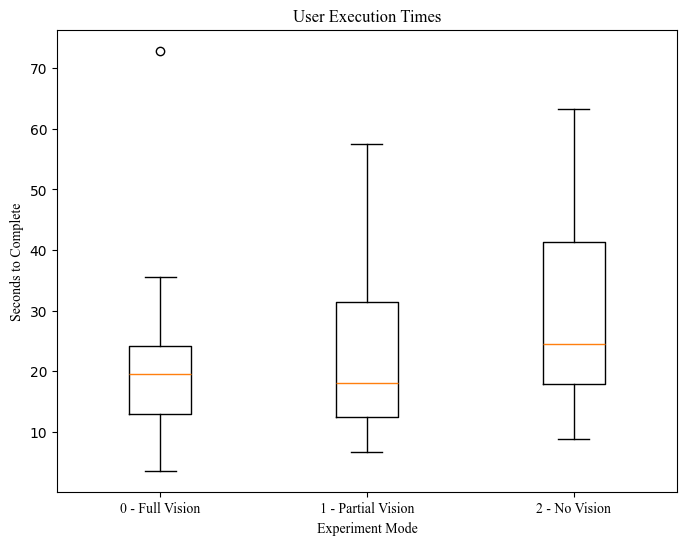

In [19]:
fig = plt.figure(figsize =(8, 6))
plt.boxplot((mode0_times, mode1_times, mode2_times))
plt.title("User Execution Times", **tnr)
plt.ylabel("Seconds to Complete", **tnr)
plt.xticks(np.arange(3)+1, ('0 - Full Vision', '1 - Partial Vision', '2 - No Vision'), **tnr)
plt.xlabel('Experiment Mode', **tnr)
plt.show()

fig.savefig('Images/boxPlots/ExecutionBoxPlots.png')

Plot completion times.

102: (24.798, 12.397, 34.401)


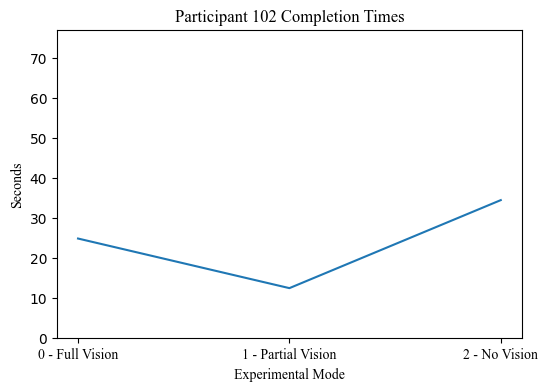

103: (16.676, 12.401, 19.965)


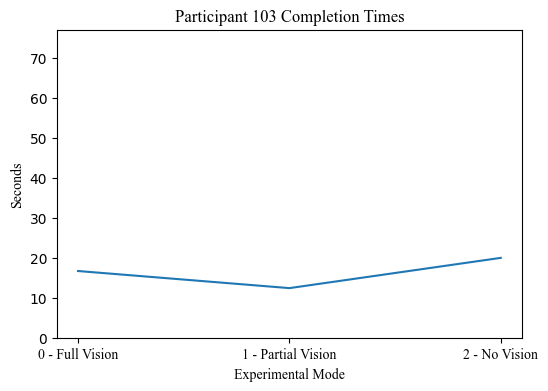

104: (11.574, 15.669, 17.671)


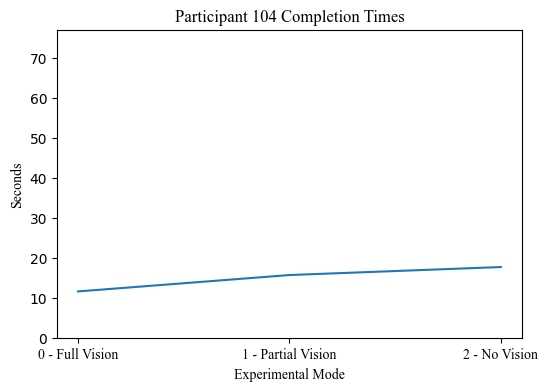

105: (16.771, 12.035, 14.965)


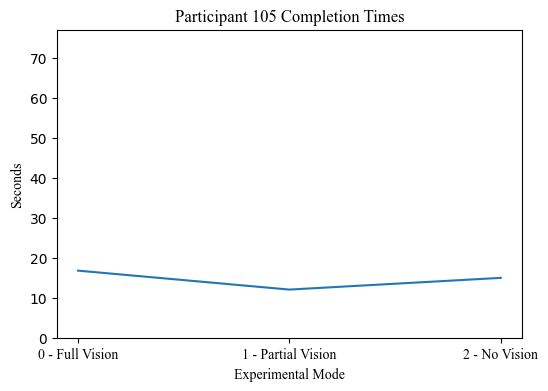

106: (18.743, 20.361, 18.47)


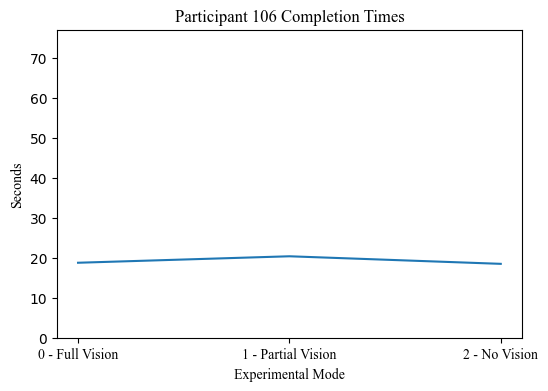

107: (21.981, 24.934, 49.905)


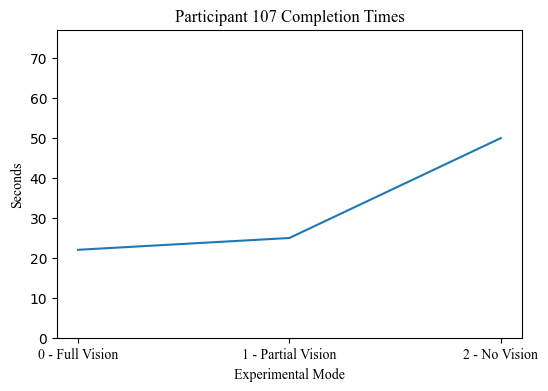

108: (20.48, 28.566, 27.77)


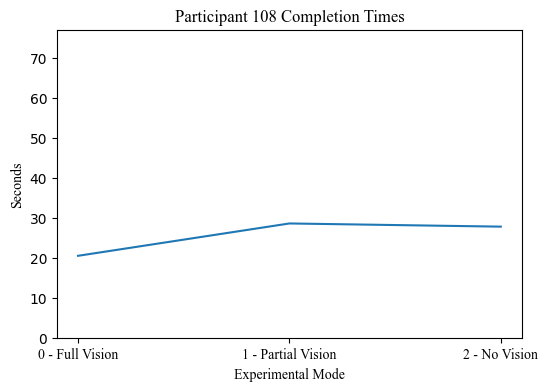

205: (9.097, 7.604, 8.804)


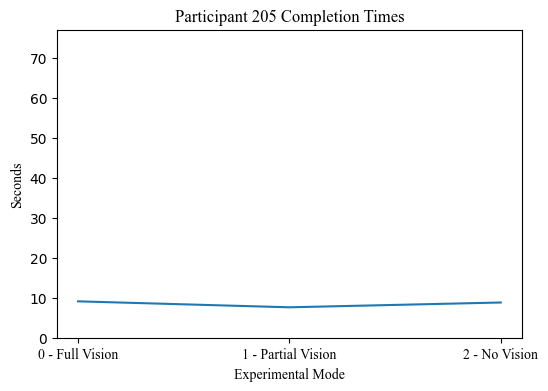

206: (3.559, 14.784, 21.206)


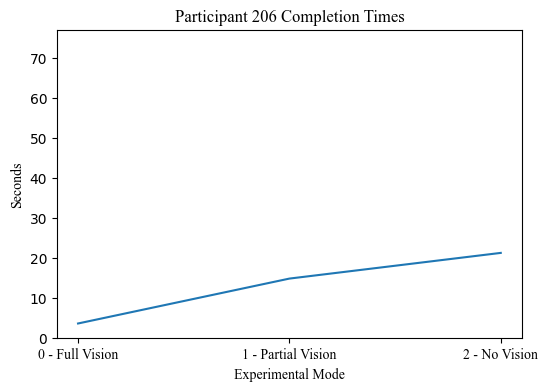

208: (9.557, 6.675, 9.606)


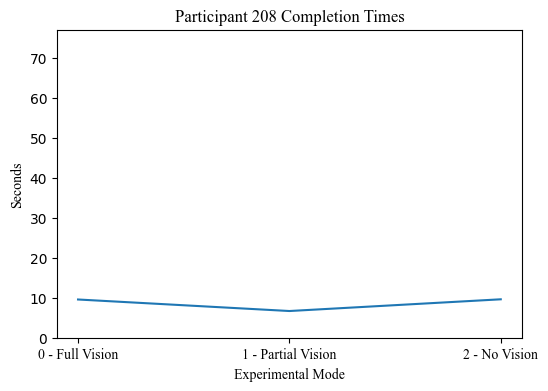

210: (72.903, 57.437, 63.2)


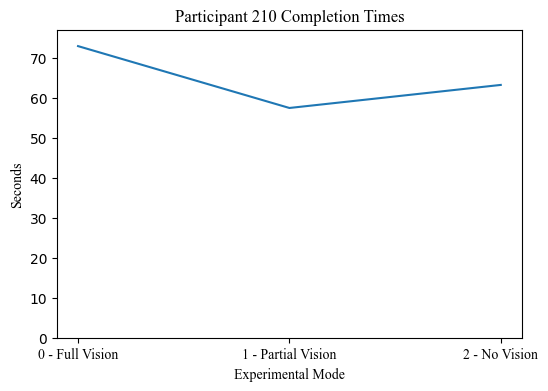

300: (31.415, 41.353, 35.532)


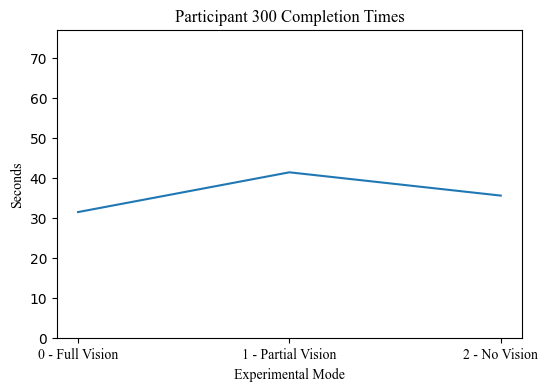

301: (20.472, 32.493, 43.955)


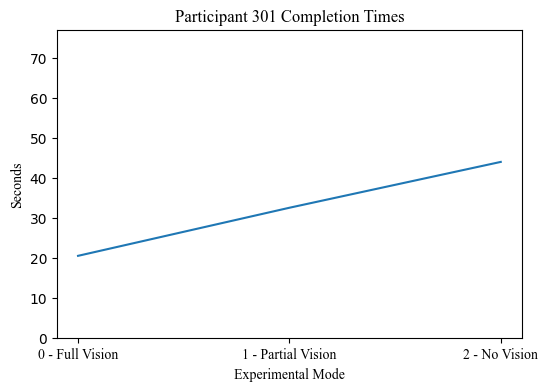

302: (35.501, 32.328, 43.206)


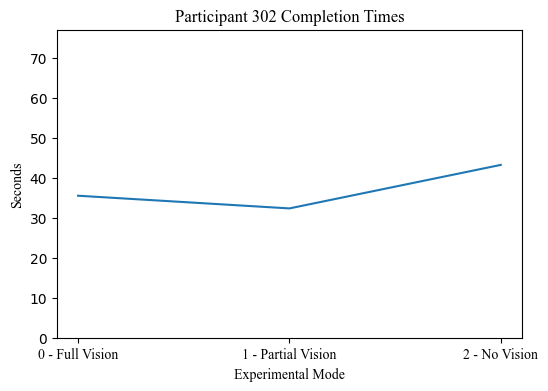

In [20]:
# print(mode0)
user_times:dict = {}
for i in range(len(mode0)):
    pid = mode0[i][12:15]
    set = (mode0_times[i], mode1_times[i], mode2_times[i])
    user_times[pid] = set
    # print(f'{i}: {pid}, {set}')
    
for k,v in user_times.items():
    title = f'{k} Completion Times'
    x = (0,1,2)
    xticks = ('0 - Full Vision', '1 - Partial Vision', '2 - No Vision')
    y = v
    ymax = int(max(mode0_stats['maximum'],mode1_stats['maximum'],mode2_stats['maximum']))+5
    print(f'{k}: {y}')
    fig = plt.figure(figsize =(6, 4))
    plt.title(f'Participant {title}', **tnr)
    plt.xticks(np.arange(3), ('0 - Full Vision', '1 - Partial Vision', '2 - No Vision'), **tnr)
    plt.ylim((0,ymax))
    
    plt.xlabel("Experimental Mode", **tnr)
    plt.ylabel("Seconds", **tnr)
    
    plt.plot(x,y)
    plt.show()
    filename = title.replace(' ','-').lower()
    fig.savefig(f'Images/userCompletionTimes/{filename}.png')
    

Multi-plot of completion times.

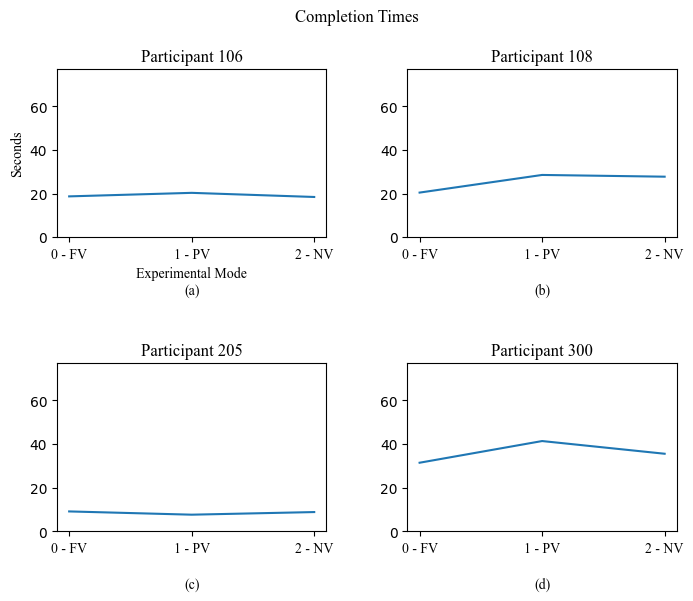

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(6)
fig.set_figwidth(8)

ax1.plot(user_times['106'])
ax2.plot(user_times['108'])
ax3.plot(user_times['205'])
ax4.plot(user_times['300'])


# ax1.set_xlabel("iPhone 8")

ax1.set_xticks(np.arange(3), ('0 - FV', '1 - PV', '2 - NV'), **tnr)
ax2.set_xticks(np.arange(3), ('0 - FV', '1 - PV', '2 - NV'), **tnr)
ax3.set_xticks(np.arange(3), ('0 - FV', '1 - PV', '2 - NV'), **tnr)
ax4.set_xticks(np.arange(3), ('0 - FV', '1 - PV', '2 - NV'), **tnr)
ax1.set_ylim((0,ymax))
ax2.set_ylim((0,ymax))
ax3.set_ylim((0,ymax))
ax4.set_ylim((0,ymax))

ax1.set_ylabel("Seconds", **tnr)
# ax2.set_xlabel("iPhone 15 Pro MAX")
ax1.set_title("Participant 106", **tnr)
ax2.set_title("Participant 108", **tnr)
ax3.set_title("Participant 205", **tnr)
ax4.set_title("Participant 300", **tnr)
ax1.set_xlabel("Experimental Mode\n(a)", **tnr)
ax2.set_xlabel("\n(b)", **tnr)
ax3.set_xlabel("\n(c)", **tnr)
ax4.set_xlabel("\n(d)", **tnr)


# plt.boxplot([ip8_avg, ip15_avg])
plt.suptitle("Completion Times", **tnr)
# plt.ylabel("Miliseconds Per Frame")
plt.subplots_adjust(wspace=0.3, hspace=0.75) 
plt.show()

fig.savefig(f'Images/userCompletionTimes/Slower1s.png')

